# Craft a Story from a Dataset Exercise: London Calling

This data story builds on the London Calling project from unit 4.3. <br>


## Data Wrangling
* Note: This step is repeating what was done for the London Calling project.

In [143]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import qgrid
def view(df_test):
    return qgrid.show_grid(df_test, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})

In [228]:
#Get Data
url_LondonHousePrices = "https://data.london.gov.uk/download/uk-house-price-index/70ac0766-8902-4eb5-aab5-01951aaed773/UK%20House%20price%20index.xls"

# Put this data into a variable called properties.  
properties = pd.read_excel(url_LondonHousePrices, sheet_name='Average price', index_col= None)

In [234]:
#Transpose data to gather all London boroughs into a single column/at London Borough level
properties2 = properties.transpose()


#Reset index to be a range
properties2 = properties2.reset_index()
properties2.index

#to set first row of data as column headers
properties2.columns = properties2.iloc[0]
properties2 = properties2.drop(0)

#Rename first two columns to represent data within
properties2 = properties2.rename(columns={properties2.columns[0]: 'Borough', properties2.columns[1]: 'Borough_Code'})


#Melt dataframe so average prices are in one column by date
properties2 = pd.melt(properties2, id_vars=['Borough','Borough_Code'])

#Rename date and average price columns
properties2 = properties2.rename(columns={0: 'Dates', 'value': 'Average_Prices'})


#Edit type of Average_Prices
properties2 = properties2.astype({"Average_Prices": float})

#Create list of 32 boroughs
boroughs = ['Barking & Dagenham','Barnet','Bexley','Brent','Bromley','Camden','Croydon','Ealing' ,'Enfield' ,'Greenwich',
'Hackney','Hammersmith & Fulham','Haringey','Harrow','Havering','Hillingdon','Hounslow','Islington','Kensington & Chelsea',
'Kingston upon Thames','Lambeth','Lewisham','Merton','Newham','Redbridge','Richmond upon Thames','Southwark','Sutton',
'Tower Hamlets','Waltham Forest','Wandsworth','Westminster']


#Create filtered dataframe with only the 32 boroughs in rows
properties_filtered = properties2[properties2['Borough'].isin(boroughs)].copy()

#Lambda function to extract year from 'Dates' column
properties_filtered['Year'] = properties_filtered.apply(lambda x: x['Dates'].year,axis=1)


#filter dataframe to 1998 - 2018 for analysis
properties_final = properties_filtered[properties_filtered['Year']>=2010]

#Reset index
properties_final = properties_final.reset_index().drop(columns='index').copy()

In [235]:
#View cleaned data
properties_final.head()

,Borough,Borough_Code,Dates,Average_Prices,Year
0,Barking & Dagenham,E09000002,2010-01-01,162905.2109,2010
1,Barnet,E09000003,2010-01-01,316925.7401,2010
2,Bexley,E09000004,2010-01-01,197737.1877,2010
3,Brent,E09000005,2010-01-01,273217.8441,2010
4,Bromley,E09000006,2010-01-01,260713.9077,2010


In [238]:
#Add ratios column
def create_price_ratio(borough):
    borough_subset = properties_final[properties_final['Borough']==borough]
    by_year = borough_subset.groupby('Year')
    mean_by_year = by_year['Average_Prices'].mean()
    ratio_2010_2020 = mean_by_year[2010]/mean_by_year[2020]
    return ratio_2010_2020

#Adding %change for data story
def create_pct_change(borough):
    borough_subset = properties_final[properties_final['Borough']==borough]
    by_year = borough_subset.groupby('Year')
    mean_by_year = by_year['Average_Prices'].mean()
    pct_change_2010_2020 = (mean_by_year[2020] - mean_by_year[2010])/mean_by_year[2010]
    return pct_change_2010_2020

#create col var to iterate through each unique borough
col = properties_final['Borough'].unique()
#Create empty dict to add borough and ratio lists
ratios_dict = {}
#Create empty borough and ratio lists to populate in for loop
borough_list = []
ratio_list = []
#Adding % change as well
pct_change_list = []

#for loop creating dict of boroughs and ratios to be converted into dataframe
for borough in col:
    borough_list += [borough]
    ratio_list += [create_price_ratio(borough)]
    pct_change_list += [create_pct_change(borough)]
    ratios_dict = {'Borough': borough_list, 'Ratio_2010_2020': ratio_list, 'Pct_Change_2010_2020':pct_change_list}

#creates final dataframe for analysis
ratios_df = pd.DataFrame(ratios_dict)

In [239]:
#View ratios_df
ratios_df.head()

,Borough,Ratio_2010_2020,Pct_Change_2010_2020
0,Barking & Dagenham,0.551104,0.814538
1,Barnet,0.633258,0.579136
2,Bexley,0.584963,0.709511
3,Brent,0.595710,0.678669
4,Bromley,0.622485,0.606465


## EDA

In [240]:
#Inspect properties_final
properties_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4288 entries, 0 to 4287
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Borough         4288 non-null   object        
 1   Borough_Code    4288 non-null   object        
 2   Dates           4288 non-null   datetime64[ns]
 3   Average_Prices  4288 non-null   float64       
 4   Year            4288 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 167.6+ KB


In [241]:
#View descriptives
properties_final.describe()

,Average_Prices,Year
count,4.288000e+03,4288.000000
mean,4.454910e+05,2015.089552
std,2.106555e+05,3.222183
min,1.608954e+05,2010.000000
25%,3.050490e+05,2012.000000
50%,3.999000e+05,2015.000000
75%,5.112768e+05,2018.000000
max,1.463378e+06,2021.000000


In [242]:
#View descriptives for Avergae price by borough
properties_final.drop(columns='Year').groupby(by='Borough').describe()

Average_Prices                                            \
                              count          mean            std          min   
Borough                                                                         
Barking & Dagenham            134.0  2.341831e+05   58248.656341  160895.3769   
Barnet                        134.0  4.520592e+05   82106.289579  316925.7401   
Bexley                        134.0  2.755228e+05   61322.454126  197426.9094   
Brent                         134.0  4.113554e+05   82472.903067  273217.8441   
Bromley                       134.0  3.689585e+05   72170.880717  260713.9077   
Camden                        134.0  7.313529e+05  123377.605386  454547.2348   
Croydon                       134.0  3.024144e+05   67300.538780  211896.3395   
Ealing                        134.0  4.092555e+05   77619.108782  283234.0258   
Enfield                       134.0  3.276529e+05   67392.473999  232751.7451   
Greenwich                     134.0  3.214927e+05   70117.570135  221333.1360   
Hackney                       134.0  4.601246e+05  107094.985867  294224.8844   
Hammersmith & Fulham          134.0  6.718445e+05   96321.739736  484952.5732   
Haringey                      134.0  4.574962e+05   98293.304451  295080.1857   
Harrow                        134.0  3.899136e+05   72188.728626  279518.7321   
Havering                      134.0  2.964589e+05   65244.695993  212880.9463   
Hillingdon                    134.0  3.403386e+05   69793.804223  239574.8445   
Hounslow                      134.0  3.423825e+05   60458.799991  250674.7766   
Islington                     134.0  5.679422e+05  101459.448130  368461.1135   
Kensington & Chelsea          134.0  1.185476e+06  182364.211083  778621.7630   
Kingston upon Thames          134.0  4.178913e+05   77981.679418  286627.8645   
Lambeth                       134.0  4.359165e+05   90935.085479  285833.1553   
Lewisham                      134.0  3.365395e+05   80135.241984  221052.4145   
Merton                        134.0  4.293053e+05   91036.523493  283608.1669   
Newham                        134.0  2.931860e+05   69595.580996  194632.3566   
Redbridge                     134.0  3.437770e+05   70019.465592  242080.5497   
Richmond upon Thames          134.0  5.746359e+05   99525.798908  411911.9920   
Southwark                     134.0  4.320613e+05   86548.412219  274107.5821   
Sutton                        134.0  3.144453e+05   62771.622439  225973.1626   
Tower Hamlets                 134.0  3.860187e+05   75299.898821  273785.1983   
Waltham Forest                134.0  3.448108e+05   93831.791278  214784.1031   
Wandsworth                    134.0  5.258044e+05   94255.487827  356193.0377   
Westminster                   134.0  8.750953e+05  159016.181377  578829.1742   

                                                                              
                               25%           50%           75%           max  
Borough                                                                       
Barking & Dagenham    1.692908e+05  2.387186e+05  2.935498e+05  3.239539e+05  
Barnet                3.626592e+05  4.760589e+05  5.294049e+05  5.494012e+05  
Bexley                2.056739e+05  2.778505e+05  3.381405e+05  3.634116e+05  
Brent                 3.231794e+05  4.359656e+05  4.860481e+05  5.222393e+05  
Bromley               2.856940e+05  3.867809e+05  4.368983e+05  4.648676e+05  
Camden                6.137184e+05  7.871135e+05  8.299855e+05  8.902884e+05  
Croydon               2.235287e+05  3.096587e+05  3.687929e+05  3.953627e+05  
Ealing                3.259169e+05  4.426786e+05  4.773433e+05  5.206736e+05  
Enfield               2.536558e+05  3.397448e+05  3.944567e+05  4.177167e+05  
Greenwich             2.412300e+05  3.396531e+05  3.872229e+05  4.212206e+05  
Hackney               3.382194e+05  5.100367e+05  5.523880e+05  6.071497e+05  
Hammersmith & Fulham  5.958994e+05  7.167014e+05  7.456125e+05  7.811750e+05  


In [243]:
#View boroughs by avg. prices overall
properties_final.drop(columns='Year').groupby(by='Borough').mean()

,Average_Prices
Borough,
Barking & Dagenham,2.341831e+05
Barnet,4.520592e+05
Bexley,2.755228e+05
Brent,4.113554e+05
Bromley,3.689585e+05
Camden,7.313529e+05
Croydon,3.024144e+05
Ealing,4.092555e+05
Enfield,3.276529e+05


#### Create a map displaying target regions: Camden, Hackney, Islington

In [245]:
#Code adapted from: https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d

# set the filepath and load in a shapefile
fp = "London-wards-2018/London-wards-2018_ESRI/London_Ward_CityMerged.shp"
map_df = gpd.read_file(fp)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df.head()

,NAME,GSS_CODE,DISTRICT,LAGSSCODE,HECTARES,NONLD_AREA,geometry
0,Chessington South,E05000405,Kingston upon Thames,E09000021,755.173,0.0,"POLYGON ((516401.596 160201.802, 516407.302 16..."
1,Tolworth and Hook Rise,E05000414,Kingston upon Thames,E09000021,259.464,0.0,"POLYGON ((519552.998 164295.600, 519508.096 16..."
2,Berrylands,E05000401,Kingston upon Thames,E09000021,145.390,0.0,"POLYGON ((518107.499 167303.399, 518114.301 16..."
3,Alexandra,E05000400,Kingston upon Thames,E09000021,268.506,0.0,"POLYGON ((520336.700 165105.498, 520332.198 16..."
4,Beverley,E05000402,Kingston upon Thames,E09000021,187.821,0.0,"POLYGON ((521201.203 169275.505, 521204.303 16..."


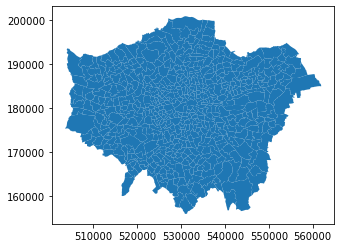

In [246]:
#View blank map
map_df.plot()
plt.show()

In [247]:
#Add column to ratios_df to give a high value to key boroughs: Hackney, Camden, Islington
ratios_df['Borough_Heat'] = np.where((ratios_df['Borough'] == 'Hackney'),100,15)
ratios_df['Borough_Heat'] = np.where((ratios_df['Borough'] == 'Camden'),75,ratios_df['Borough_Heat'])
ratios_df['Borough_Heat'] = np.where((ratios_df['Borough'] == 'Islington'),50,ratios_df['Borough_Heat'])
ratios_df.head(10)

,Borough,Ratio_2010_2020,Pct_Change_2010_2020,Borough_Heat
0,Barking & Dagenham,0.551104,0.814538,15
1,Barnet,0.633258,0.579136,15
2,Bexley,0.584963,0.709511,15
3,Brent,0.595710,0.678669,15
4,Bromley,0.622485,0.606465,15
5,Camden,0.616516,0.622017,75
6,Croydon,0.582715,0.716105,15
7,Ealing,0.609439,0.640854,15
8,Enfield,0.611244,0.636008,15
9,Greenwich,0.578797,0.727720,15


In [248]:
#Clean borough names to be able to merge with map data
ratios_df['Borough'] = ratios_df['Borough'].str.replace('&','and')
ratios_df['Borough'] = ratios_df['Borough'].str.replace('Westminster','City of Westminster')

In [249]:
#Merge ratios_df with borough map
merged = map_df.set_index('DISTRICT').join(ratios_df.set_index('Borough'))
merged.head()

,NAME,GSS_CODE,LAGSSCODE,HECTARES,NONLD_AREA,geometry,Ratio_2010_2020,Pct_Change_2010_2020,Borough_Heat
Barking and Dagenham,Gascoigne,E05000032,E09000002,113.874,4.906,"POLYGON ((543574.498 183951.404, 543571.702 18...",0.551104,0.814538,15.0
Barking and Dagenham,Thames,E05000039,E09000002,788.848,120.125,"POLYGON ((545802.000 181308.800, 545798.397 18...",0.551104,0.814538,15.0
Barking and Dagenham,River,E05000038,E09000002,354.369,41.464,"POLYGON ((549072.799 183605.103, 549074.102 18...",0.551104,0.814538,15.0
Barking and Dagenham,Village,E05000041,E09000002,214.748,0.000,"POLYGON ((549049.301 184708.297, 549070.202 18...",0.551104,0.814538,15.0
Barking and Dagenham,Abbey,E05000026,E09000002,128.292,2.655,"POLYGON ((544735.196 184076.498, 544726.596 18...",0.551104,0.814538,15.0


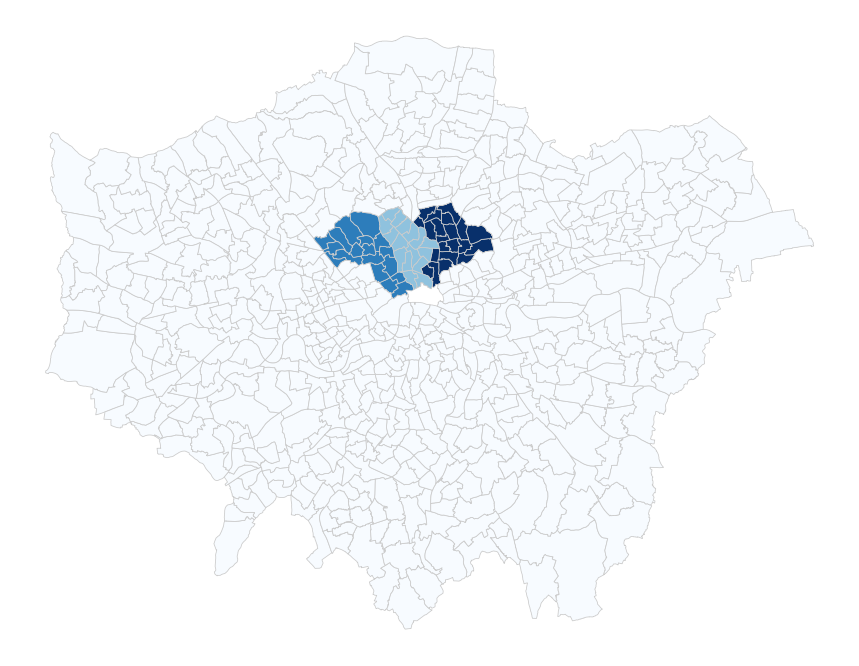

In [250]:
# Set Borough_Heat as value to view on the map so that the target boroughs stand out
variable = 'Borough_Heat'
# set the range for the choropleth
vmin, vmax = 120, 220
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 12))
ax.axis('off')
# create map
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
plt.show()

In [264]:
#Filter to 2020
properties_2020 = properties_final[properties_final['Year']==2020].copy()

In [316]:
#Add Borough_Heat column to give a high value to key boroughs: Hackney, Camden, Islington
properties_2020['Target_Borough'] = np.where((properties_2020['Borough'] == 'Hackney'),'navy','lightblue')
properties_2020['Target_Borough'] = np.where((properties_2020['Borough'] == 'Camden'),'navy',properties_2020['Target_Borough'])
properties_2020['Target_Borough'] = np.where((properties_2020['Borough'] == 'Islington'),'navy',properties_2020['Target_Borough'])
properties_2020.head(10)

,Borough,Borough_Code,Dates,Average_Prices,Year,Target_Borough,Avg_Price_Cond
3954,Kensington & Chelsea,E09000020,2020-04-01,1366507.988,2020,lightblue,1366.51
3986,Kensington & Chelsea,E09000020,2020-05-01,1353405.021,2020,lightblue,1353.41
4114,Kensington & Chelsea,E09000020,2020-09-01,1347732.643,2020,lightblue,1347.73
4082,Kensington & Chelsea,E09000020,2020-08-01,1344349.768,2020,lightblue,1344.35
3922,Kensington & Chelsea,E09000020,2020-03-01,1344119.853,2020,lightblue,1344.12
4210,Kensington & Chelsea,E09000020,2020-12-01,1338536.464,2020,lightblue,1338.54
4178,Kensington & Chelsea,E09000020,2020-11-01,1324295.846,2020,lightblue,1324.30
4050,Kensington & Chelsea,E09000020,2020-07-01,1321046.625,2020,lightblue,1321.05
3890,Kensington & Chelsea,E09000020,2020-02-01,1319105.745,2020,lightblue,1319.11
4146,Kensington & Chelsea,E09000020,2020-10-01,1302911.837,2020,lightblue,1302.91


In [294]:
#Create condensed avg. price column
properties_2020['Avg_Price_Cond'] = round(properties_2020['Average_Prices'] / 1000,2)
properties_2020.head()

,Borough,Borough_Code,Dates,Average_Prices,Year,Target_Borough,Avg_Price_Cond
3840,Barking & Dagenham,E09000002,2020-01-01,303055.4403,2020,0,303.06
3841,Barnet,E09000003,2020-01-01,521433.7527,2020,0,521.43
3842,Bexley,E09000004,2020-01-01,336780.1407,2020,0,336.78
3843,Brent,E09000005,2020-01-01,428085.2389,2020,0,428.09
3844,Bromley,E09000006,2020-01-01,434196.5269,2020,0,434.20


In [318]:
#Create values for bar chart
properties_2020 = properties_2020.sort_values(by='Average_Prices', ascending=False)
x = properties_2020['Borough']
y = properties_2020['Avg_Price_Cond']
colors = properties_2020['Target_Borough']

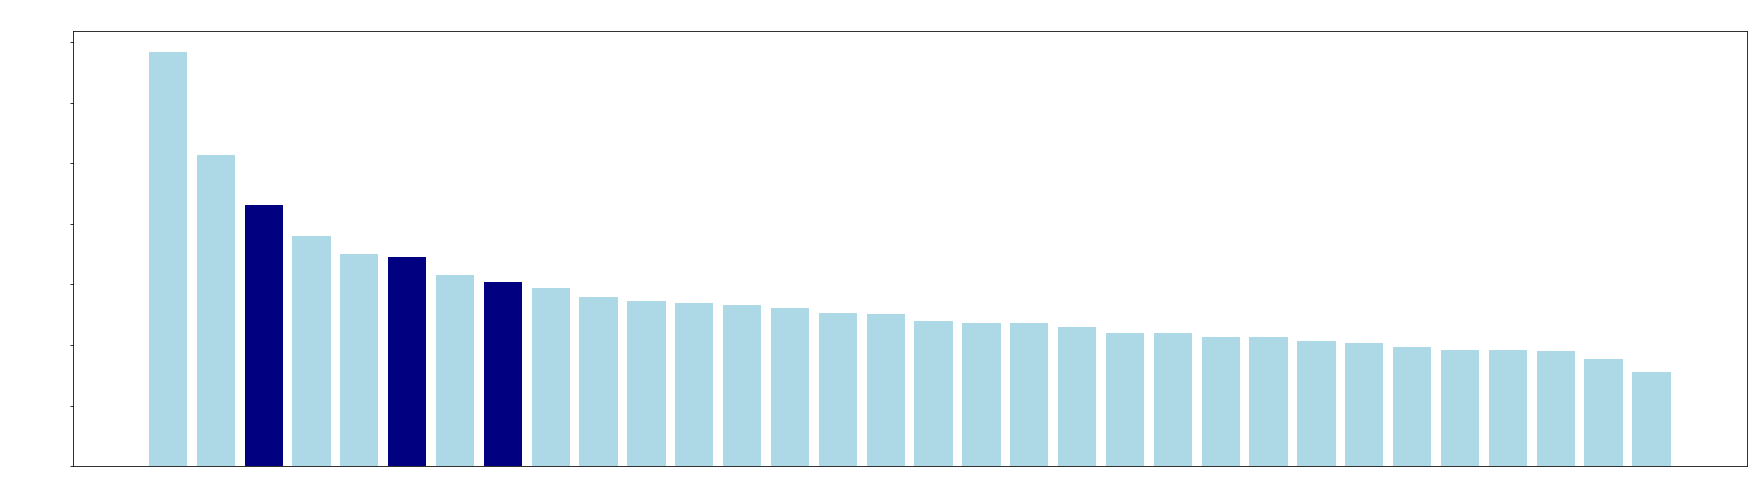

In [330]:
#Format Chart - all white labels to paste into slide deck
fig=plt.figure(figsize=(30,8))
with plt.style.context('seaborn-colorblind'):
    plt.bar(x, y, color=colors)
    plt.tick_params(
    axis='x',         
    which='both',
    bottom=False,     
    top=False,        
    labelbottom=False)
    plt.yticks(color='white',fontsize=14)
    plt.ylabel('Avg. Housing Price (in thousands £ GBP)', fontsize=20, color='white')
    plt.title('Avg. Housing Price in 2020 (£ GBP) by London Borough',fontsize=24, color='white')
plt.show()

In [331]:
#Print the boroughs to paste into labels in slide deck
for i in properties_2020['Borough'].unique():
    print(i)

Kensington & Chelsea
Westminster
Camden
Hammersmith & Fulham
Richmond upon Thames
Islington
Wandsworth
Hackney
Haringey
Merton
Lambeth
Southwark
Barnet
Brent
Kingston upon Thames
Ealing
Tower Hamlets
Waltham Forest
Harrow
Bromley
Redbridge
Lewisham
Hillingdon
Hounslow
Enfield
Greenwich
Sutton
Newham
Croydon
Havering
Bexley
Barking & Dagenham


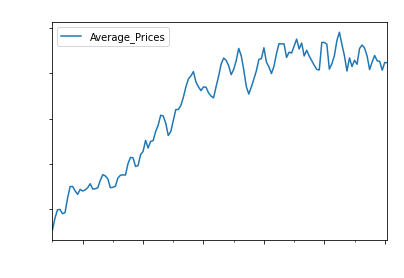

In [373]:
#Line Plot of property price growth from 2010 to 2020 for each of top 3 boroughs
properties_final[properties_final['Borough'] == 'Camden'].plot(x='Dates', y='Average_Prices')
plt.xlabel('Years', color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.title('Avg. Housing Price 2010-2021: Camden',color='white')
plt.show()

In [336]:
#Get average price ratio 2010 to 2020
print(ratios_df[ratios_df['Borough'] == 'Camden']['Ratio_2010_2020'])
print(ratios_df[ratios_df['Borough'] == 'Camden']['Pct_Change_2010_2020'])

5    0.616516
Name: Ratio_2010_2020, dtype: float64
5    0.622017
Name: Pct_Change_2010_2020, dtype: float64


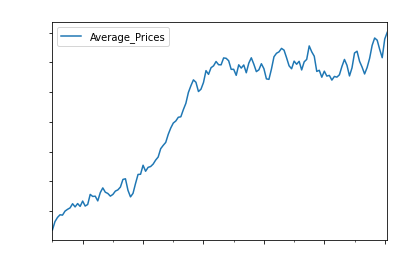

In [339]:
#Line Plot of property price growth from 2010 to 2020 for each of top 3 boroughs
properties_final[properties_final['Borough'] == 'Islington'].plot(x='Dates', y='Average_Prices')
plt.xlabel('Years', color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.title('Avg. Housing Price 2010-2021: Islington',color='white')
plt.show()

In [337]:
#Get average price ratio 2010 to 2020
print(ratios_df[ratios_df['Borough'] == 'Islington']['Ratio_2010_2020'])
print(ratios_df[ratios_df['Borough'] == 'Islington']['Pct_Change_2010_2020'])

17    0.601202
Name: Ratio_2010_2020, dtype: float64
17    0.663334
Name: Pct_Change_2010_2020, dtype: float64


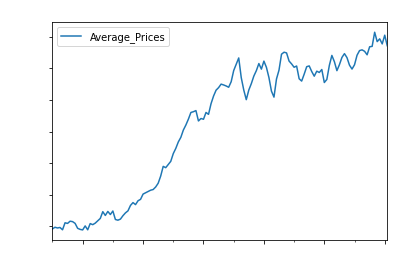

In [340]:
#Line Plot of property price growth from 2010 to 2020 for each of top 3 boroughs
properties_final[properties_final['Borough'] == 'Hackney'].plot(x='Dates', y='Average_Prices')
plt.xlabel('Years', color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.title('Avg. Housing Price 2010-2021: Hackney',color='white')
plt.show()

In [341]:
#Get average price ratio 2010 to 2020
print(ratios_df[ratios_df['Borough'] == 'Hackney']['Ratio_2010_2020'])
print(ratios_df[ratios_df['Borough'] == 'Hackney']['Pct_Change_2010_2020'])

10    0.516155
Name: Ratio_2010_2020, dtype: float64
10    0.937402
Name: Pct_Change_2010_2020, dtype: float64


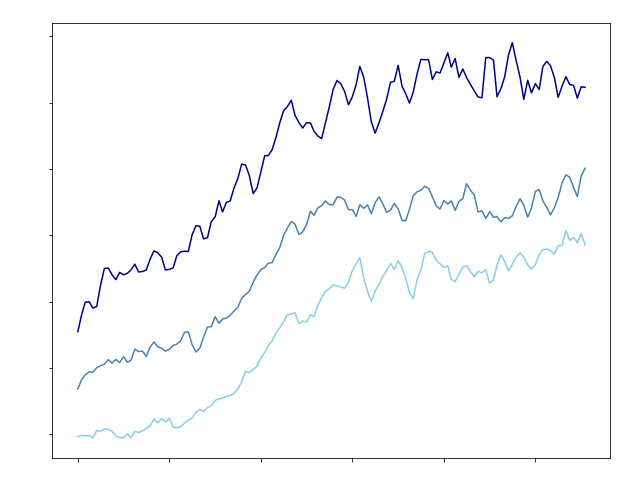

In [364]:
#Line Plot of property price growth from 2010 to 2020 for each of top 3 boroughs
properties_target = properties_final[(properties_final['Borough'] == 'Camden')|(properties_final['Borough'] == 'Islington')|(properties_final['Borough'] == 'Hackney')]

x_1 = properties_target[properties_target['Borough'] == 'Camden']['Dates']
x_2 = properties_target[properties_target['Borough'] == 'Islington']['Dates']
x_3 = properties_target[properties_target['Borough'] == 'Hackney']['Dates']
y_1 = properties_target[properties_target['Borough'] == 'Camden']['Average_Prices']
y_2 = properties_target[properties_target['Borough'] == 'Islington']['Average_Prices']
y_3 = properties_target[properties_target['Borough'] == 'Hackney']['Average_Prices']

fig=plt.figure(figsize=(10,8))
plt.plot(x_1, y_1, color='navy')
plt.plot(x_2, y_2, color='steelblue')
plt.plot(x_3, y_3, color='skyblue')
plt.xlabel('Years', color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.title('Avg. Housing Price 2010-2021',color='white')
plt.show()

In [356]:
#Get price differences at 2010, 2015, and 2020 to show gap

Camden_mean_2010 = properties_target[((properties_target['Borough'] == 'Camden') & (properties_target['Year'] == 2010))]['Average_Prices'].mean()
Camden_mean_2015 = properties_target[((properties_target['Borough'] == 'Camden') & (properties_target['Year'] == 2015))]['Average_Prices'].mean()
Camden_mean_2020 = properties_target[((properties_target['Borough'] == 'Camden') & (properties_target['Year'] == 2020))]['Average_Prices'].mean()
Islington_mean_2010 = properties_target[((properties_target['Borough'] == 'Islington') & (properties_target['Year'] == 2010))]['Average_Prices'].mean()
Islington_mean_2015 = properties_target[((properties_target['Borough'] == 'Islington') & (properties_target['Year'] == 2015))]['Average_Prices'].mean()
Islington_mean_2020 = properties_target[((properties_target['Borough'] == 'Islington') & (properties_target['Year'] == 2020))]['Average_Prices'].mean()
Hackney_mean_2010 = properties_target[((properties_target['Borough'] == 'Hackney') & (properties_target['Year'] == 2010))]['Average_Prices'].mean()
Hackney_mean_2015 = properties_target[((properties_target['Borough'] == 'Hackney') & (properties_target['Year'] == 2015))]['Average_Prices'].mean()
Hackney_mean_2020 = properties_target[((properties_target['Borough'] == 'Hackney') & (properties_target['Year'] == 2020))]['Average_Prices'].mean()

In [374]:
#2010
print((Camden_mean_2010-Islington_mean_2010)/((Camden_mean_2010+Islington_mean_2010)/2))
print((Camden_mean_2010-Hackney_mean_2010)/((Camden_mean_2010+Hackney_mean_2010)/2))
print((Islington_mean_2010-Hackney_mean_2010)/((Islington_mean_2010+Hackney_mean_2010)/2))

0.2527574265566157
0.5228636989849739
0.2793353506070873


In [375]:
#2020
print((Camden_mean_2020-Islington_mean_2020)/((Camden_mean_2020+Islington_mean_2020)/2))
print((Camden_mean_2020-Hackney_mean_2020)/((Camden_mean_2010+Hackney_mean_2020)/2))
print((Islington_mean_2020-Hackney_mean_2020)/((Islington_mean_2020+Hackney_mean_2020)/2))

0.2279672490396992
0.4569713825747813
0.12847225539040827


In [376]:
#Look at 3 year % change for Hackney
Hackney_mean_2017 = properties_target[((properties_target['Borough'] == 'Hackney') & (properties_target['Year'] == 2017))]['Average_Prices'].mean()
Hackney_mean_2017 = properties_target[((properties_target['Borough'] == 'Hackney') & (properties_target['Year'] == 2017))]['Average_Prices'].mean()


print(Hackney_mean_2020-Hackney_mean_2017/Hackney_mean_2017)

582170.7087833333
